# **SVHN Dataset**
In the following exercices, you will work with the SVHN dataset: http://ufldl.stanford.edu/housenumbers/

It contains RGB images of street digits labeled from 1 to 10 similar to the MNIST dataset.

The train and test sets are provided in the folder Data/svhn/ in .mat format.
In the following we show an example of how to load the images and labels from these files. A DataLoader for this dataset is provided in the code examples for the lab.

Label: 1


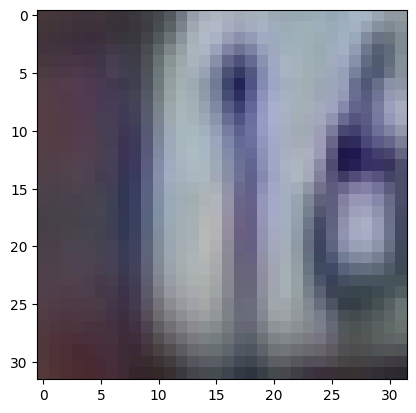

In [2]:
# Basic example loading images from the svhn dataset
import scipy.io as sio
import matplotlib.pyplot as plt
import numpy as np
import os
import torch
import torch.nn as nn

try: 
    base_path
except NameError:
    base_path = os.getcwd().replace('\\','/')
data_path = base_path + '/Data/'
results_path = base_path + '/Results/'

# Load mat file with train images from SVHN
import scipy.io as sio
train_mat = sio.loadmat(data_path + 'svhn/train_32x32.mat')

images = train_mat['X']
labels = train_mat['y'].squeeze()

example_image, example_label = images[:,:,:,20], labels[20] 

print('Label: ' + str(example_label))
plt.imshow(example_image)

# Ex. 1


'''
1. Try to obtain the maximum test accuracy possible in the SVHN dataset. For this purpose train/test different variants of the CNN provided in P3-Part1-Examples.
   You can explore different strategies:
1.1. Increase the size of the network by adding one ore more conv. layers. You can also increase the number of filters in each layer.
1.2. Try different optimizers such as Adam or SGD with momentum and modify the learning rate. You can check: https://pytorch.org/docs/stable/optim.html
1.3. Explore different random transformations during training ( Data augmentation ) such as random cropping with padding. 
You can check: https://pytorch.org/docs/stable/torchvision/transforms.html . Remember that these random transofrmation must not be used during testing.
1.4 Whatever you consider...


2. Save all the different models , compare their test accuracy and analyse the results. Discuss what model has been shown more effective and why have you used the different strategies.
'''

# Sol. 1

In [ ]:
#Making native class loader
import PIL.Image as Image

class SVHN(torch.utils.data.Dataset):
    # Initialization method for the dataset
    def __init__(self,dataDir = data_path+'/svhn/train_32x32.mat',transform = None):
        mat_loaded = sio.loadmat(dataDir)
        self.data = mat_loaded['X']
        self.labels = mat_loaded['y'].squeeze()
        self.labels -= self.labels.min()
        self.transform = transform
     # What to do to load a single item in the dataset ( read image and label)    
    def __getitem__(self, index):
        data = self.data[:,:,:,index]
        lbl = self.labels[index]
        
        data = Image.fromarray(data)
        # Apply a trasnformaiton to the image if it is indicated in the initalizer
        if self.transform is not None : 
            data = self.transform(data)
        
        # return the image and the label
        return data,lbl
    
        pass
    
    # Return the number of images
    def __len__(self):
        return self.data.shape[3]


## Base CNN

In [ ]:
# Define an standard CNN -> Two conv. blocks and linear layer 
import torch.nn as nn
class BaseConvNet(nn.Module):
    def __init__(self, num_classes=10):
        
        super(BaseConvNet, self).__init__()
        
        self.conv1 = nn.Conv2d(3, 16, kernel_size=5,  padding=2)
        #input : 3 channel, output 16 channel, filter size : 5x5 and padding 2
        # the ouput of this channel will be 16x32x32 (assuming our image is in fact 32x32) since the pixels
        # that the convolution operation collapses into are 32x32 (the padding is 2 so the image is not reduced)
        
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3,  padding=1)
        #input : 16 channel, output 32 channel, filter size : 3x3
        # simmilary the output of this channel will be 32x32x32. If the kernel is 3x3, then the dimensions are reduced by
        # 2 (since the padding is 1) in both height and width, but the padding counters this.
        
        self.fc = nn.Linear(8*8*32, num_classes)
        # must match the previous dimensions in the input. In the case of the SVHM dataset, the input is 32x32x3, and after
        # doing 2 convolutions that do not reduce the height and width, but 2 maxpooling operations after the convolutions, the
        # dimensions are 8x8x32, since the final channel number is 32. The 8*8*32 is the number of pixels in the image after the 
        # convolutions, and the number of channels
        
        self.maxpool= nn.MaxPool2d(kernel_size=2, stride=2)
        self.relu = nn.ReLU().cuda()
        
    def forward(self, x):
        
        out = self.conv1(x)
        out = self.relu(out)
        out = self.maxpool(out)
        
        out = self.conv2(out)
        out = self.relu(out)
        out = self.maxpool(out)
        
        out = out.reshape(out.size(0), -1) 
        out = self.fc(out) # we don't need sigmoid or other activation function at the end beacuse we will use nn.CrossEntropyLoss() (check documentation to understand why)
        
        return out 



In [ ]:
# Train function
def train(CNN, train_loader, optimizer, num_epochs=5, model_name='model.ckpt', device='cpu'):
    CNN.train() # Set the model in train mode
    total_step = len(train_loader)
    losses_list = []
    # Iterate over epochs
    for epoch in range(num_epochs):
        # Iterate the dataset
        for i, (images, labels) in enumerate(train_loader):
            # Get batch of samples and labels
            images = images.to(device)
            labels = labels.to(device)
            
            # Forward pass
            outputs = CNN(images)
            loss = criterion(outputs, labels)
            losses_list.append(loss.item())
            
            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            if (i+1) % 100 == 0:
                print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                        .format(epoch+1, num_epochs, i+1, total_step, loss.item()))
          
    torch.save(CNN.state_dict(), results_path + model_name)
    return losses_list 

# Test funcion
def test(CNN, test_loader):
  with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in test_loader:
            # get network predictions
            outputs = CNN(images)

            # get predicted class
            _, predicted = torch.max(outputs.data, 1)

            # compare with the ground-truth
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        # return accuracy
        return 100 * correct / total

In [ ]:
BaseCNN = BaseConvNet()
# CNN = CNN.cuda()
import torchvision.transforms as tf

# Create train data loader
tr = tf.Compose([
        tf.ToTensor(), 
        tf.Normalize(mean = [.5], std = [.5]),
        ])
SVHNTrain = SVHN(data_path+'/svhn/train_32x32.mat',tr)
train_loader = torch.utils.data.DataLoader(dataset=SVHNTrain,
                                               batch_size=256, 
                                               shuffle=True)

SVHNTest = SVHN(data_path+'/svhn/test_32x32.mat',tr)
test_loader = torch.utils.data.DataLoader(dataset=SVHNTest,
                                               batch_size=256, 
                                               shuffle=True)

c:\Users\erodriguez\AppData\Local\Programs\Python\Python39\lib\site-packages\torchvision\transforms\functional.py:136: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  img = torch.ByteTensor(torch.ByteStorage.from_buffer(pic.tobytes()))


Epoch [1/5], Step [100/287], Loss: 1.2437
Epoch [1/5], Step [200/287], Loss: 0.6243
Epoch [2/5], Step [100/287], Loss: 0.4715
Epoch [2/5], Step [200/287], Loss: 0.6304
Epoch [3/5], Step [100/287], Loss: 0.4976
Epoch [3/5], Step [200/287], Loss: 0.4832
Epoch [4/5], Step [100/287], Loss: 0.5711
Epoch [4/5], Step [200/287], Loss: 0.3705
Epoch [5/5], Step [100/287], Loss: 0.4586
Epoch [5/5], Step [200/287], Loss: 0.4366


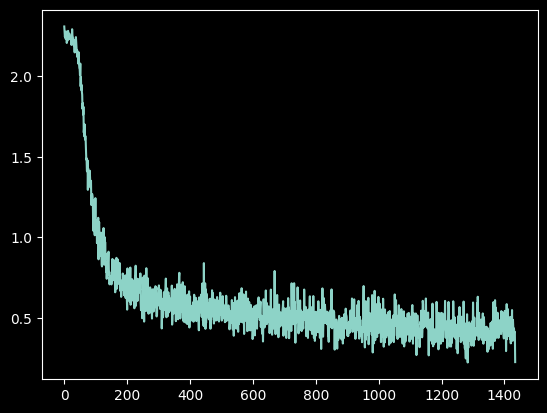

Test accuracy is: 85.81361401352181 %


In [ ]:
# Cross entropy loss for classification problems
criterion = nn.CrossEntropyLoss()

#Initialize optimizer 
learning_rate = .001
optimizer = torch.optim.Adam(BaseCNN.parameters(),lr = learning_rate)


# Device configuration (choose GPU if it is available )
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
num_epochs = 5

# Train and test the model
loss_hist = train(BaseCNN, train_loader, optimizer, num_epochs, model_name='base_model.pkt', device=device)
plt.plot(loss_hist)
plt.show()


print('Test accuracy is: {} %'.format(test(BaseCNN, test_loader)))
# Create test data loader


## Refined CNN's

We will not create a CNN class for each hyperparameter configuration. Instead, we will change the RefinedConvNet class

### More Layers or different architecture

In [ ]:
# Define an standard CNN -> Two conv. blocks and linear layer 
import torch.nn as nn
class LongConvNet(nn.Module):
    def __init__(self, num_classes=10):
        
        super(LongConvNet, self).__init__()
        
        self.conv1 = nn.Conv2d(3, 16, kernel_size=5,  padding=2) 
        # after maxpooling, the dimensions are 16x16x16
    
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5)
        # after maxpooling, the dimensions are 7x7x32

        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        # after maxpooling, the dimensions are 3x3x64
        
        self.fc1 = nn.Linear(3*3*64, 256)
        self.fc2 = nn.Linear(256, num_classes)
        
        self.maxpool= nn.MaxPool2d(kernel_size=2, stride=2)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        
        out = self.conv1(x)
        out = self.relu(out)
        out = self.maxpool(out)
        
        out = self.conv2(out)
        out = self.relu(out)
        out = self.maxpool(out)

        out = self.conv3(out)
        out = self.relu(out)
        out = self.maxpool(out)
        
        out = out.reshape(out.size(0), -1) 
        out = self.fc1(out)
        out = self.relu(out)

        out = self.fc2(out)
        
        return out 



Epoch [1/5], Step [100/287], Loss: 1.1918
Epoch [1/5], Step [200/287], Loss: 0.8696
Epoch [2/5], Step [100/287], Loss: 0.3323
Epoch [2/5], Step [200/287], Loss: 0.4316
Epoch [3/5], Step [100/287], Loss: 0.5190
Epoch [3/5], Step [200/287], Loss: 0.3019
Epoch [4/5], Step [100/287], Loss: 0.5467
Epoch [4/5], Step [200/287], Loss: 0.3222
Epoch [5/5], Step [100/287], Loss: 0.3226
Epoch [5/5], Step [200/287], Loss: 0.3979


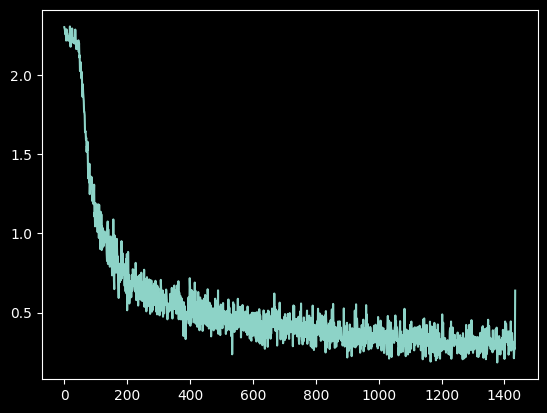

Test accuracy is: 89.33236017209589 %


In [ ]:
LongCNN = LongConvNet()

criterion = nn.CrossEntropyLoss()

#Initialize optimizer 
learning_rate = .001

# Device configuration (choose GPU if it is available )
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
num_epochs = 5

optimizer = torch.optim.Adam(LongCNN.parameters(),lr = learning_rate)

loss_hist = train(LongCNN, train_loader, optimizer, num_epochs, model_name='long_model.pkt', device=device)
# plot the loss history with a white background
plt.plot(loss_hist)
plt.show()


print('Test accuracy is: {} %'.format(test(LongCNN, test_loader)))
# Create test data loader

### Different Optimizers

In [ ]:
# Cross entropy loss for classification problems
criterion = nn.CrossEntropyLoss()

#Initialize optimizer 
learning_rate = .001
optimizer_Adam = torch.optim.Adam(BaseCNN.parameters(),lr = learning_rate)


# Device configuration (choose GPU if it is available )
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
num_epochs = 5

# Train and test the model
loss_hist = train(BaseCNN, train_loader, optimizer_Adam, num_epochs, model_name='base_model.pkt', device=device)
plt.plot(loss_hist)
plt.show()


print('Test accuracy is: {} %'.format(test(BaseCNN, test_loader)))
# Create test data loader


In [ ]:
# Cross entropy loss for classification problems
RMSpropCNN = BaseConvNet()
criterion = nn.CrossEntropyLoss()

#Initialize optimizer 
learning_rate = .001
optimizer_RMSpropCNN = torch.optim.RMSprop(RMSpropCNN.parameters(),lr = learning_rate)


# Device configuration (choose GPU if it is available )
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
num_epochs = 5

# Train and test the model
loss_hist = train(RMSpropCNN, train_loader, optimizer_RMSpropCNN, num_epochs, model_name='rmsprop_model.pkt', device=device)
plt.plot(loss_hist)
plt.show()


print('Test accuracy is: {} %'.format(test(RMSpropCNN, test_loader)))
# Create test data loader

In [ ]:
# Cross entropy loss for classification problems
SGDGCNN = BaseConvNet()
criterion = nn.CrossEntropyLoss()

#Initialize optimizer 
learning_rate = .1
optimizer_SGD = torch.optim.SGD(SGDGCNN.fc.parameters(),lr = learning_rate, weight_decay=1e-5, momentum=0.9)


# Device configuration (choose GPU if it is available )
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
num_epochs = 5

# Train and test the model
loss_hist = train(SGDGCNN, train_loader, optimizer_SGD, num_epochs, model_name='SGD_model.pkt', device=device)
plt.plot(loss_hist)
plt.show()


print('Test accuracy is: {} %'.format(test(SGDGCNN, test_loader)))
# Create test data loader

### Transormations

In [ ]:
# Create train data loader
max_degree = 10
tr_rot = tf.Compose([
        tf.ToTensor(), 
        tf.Normalize(mean = [.5], std = [.5]),
        tf.RandomRotation(max_degree)
        ])

SVHNTrain_rot = SVHN(data_path+'/svhn/train_32x32.mat',tr_rot)
train_loader_rot = torch.utils.data.DataLoader(dataset=SVHNTrain_rot,
                                               batch_size=256, 
                                               shuffle=True)

SVHNTest_rot = SVHN(data_path+'/svhn/test_32x32.mat',tr_rot)
test_loader_rot = torch.utils.data.DataLoader(dataset=SVHNTest_rot,
                                               batch_size=256, 
                                               shuffle=True)


In [ ]:
# Create train data loader
max_degree = 10
tr_crop = tf.Compose([
        tf.ToTensor(), 
        tf.Normalize(mean = [.5], std = [.5]),
        tf.RandomCrop(32, padding=4)
        ])
SVHNTrain_crop = SVHN(data_path+'/svhn/train_32x32.mat',tr_crop)
train_loader_crop = torch.utils.data.DataLoader(dataset=SVHNTrain_crop,
                                               batch_size=256, 
                                               shuffle=True)


SVHNTest_crop = SVHN(data_path+'/svhn/test_32x32.mat',tr_crop)
test_loader_crop = torch.utils.data.DataLoader(dataset=SVHNTest,
                                               batch_size=256, 
                                               shuffle=True)

Epoch [1/5], Step [100/287], Loss: 1.6737
Epoch [1/5], Step [200/287], Loss: 1.2317
Epoch [2/5], Step [100/287], Loss: 1.2649
Epoch [2/5], Step [200/287], Loss: 0.9853
Epoch [3/5], Step [100/287], Loss: 1.0814
Epoch [3/5], Step [200/287], Loss: 0.8382
Epoch [4/5], Step [100/287], Loss: 0.8512
Epoch [4/5], Step [200/287], Loss: 0.8742
Epoch [5/5], Step [100/287], Loss: 0.7662
Epoch [5/5], Step [200/287], Loss: 0.8176


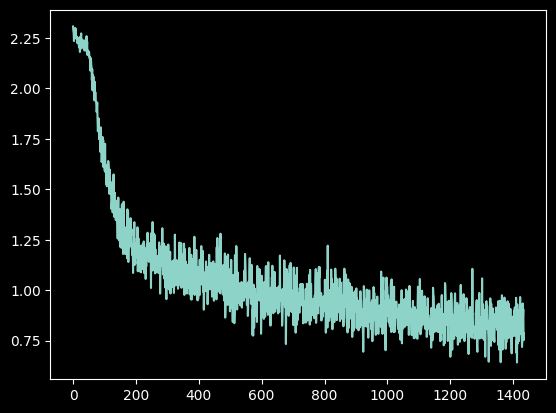

Test accuracy is: 84.0081438229871 %


In [ ]:
BaseCNN = BaseConvNet()

criterion = nn.CrossEntropyLoss()

#Initialize optimizer 
learning_rate = .001
optimizer = torch.optim.Adam(BaseCNN.parameters(), lr = learning_rate)


# Device configuration (choose GPU if it is available )
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
num_epochs = 5

# Train and test the model
loss_hist = train(BaseCNN, train_loader_crop, optimizer, num_epochs, model_name='cropped_model.pkt', device=device)
plt.plot(loss_hist)
plt.show()


print('Test accuracy is: {} %'.format(test(BaseCNN, test_loader_crop)))

Epoch [1/5], Step [100/287], Loss: 0.9952
Epoch [1/5], Step [200/287], Loss: 0.7649
Epoch [2/5], Step [100/287], Loss: 0.5483
Epoch [2/5], Step [200/287], Loss: 0.5972
Epoch [3/5], Step [100/287], Loss: 0.5186
Epoch [3/5], Step [200/287], Loss: 0.5389
Epoch [4/5], Step [100/287], Loss: 0.4933
Epoch [4/5], Step [200/287], Loss: 0.3674
Epoch [5/5], Step [100/287], Loss: 0.4698
Epoch [5/5], Step [200/287], Loss: 0.5424


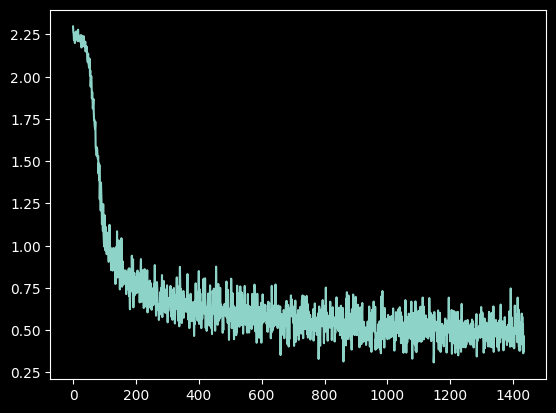

Test accuracy is: 84.81868469575906 %


In [ ]:
BaseCNN = BaseConvNet()

criterion = nn.CrossEntropyLoss()

#Initialize optimizer 
learning_rate = .001
optimizer = torch.optim.Adam(BaseCNN.parameters(), lr = learning_rate)


# Device configuration (choose GPU if it is available )
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
num_epochs = 5

# Train and test the model
loss_hist = train(BaseCNN, train_loader_rot, optimizer, num_epochs, model_name='rotated_model.pkt', device=device)
plt.plot(loss_hist)
plt.show()


print('Test accuracy is: {} %'.format(test(BaseCNN, test_loader_rot)))

### Other Alternatives

#### Schedulers

In [ ]:
# Train function
import torch.optim.lr_scheduler as lrs
def train_sched(CNN, train_loader, optimizer, num_epochs=5, model_name='scheduled_model.ckpt', device='cpu', scheduler=None,criterion=nn.CrossEntropyLoss()):
    CNN.train() # Set the model in train mode
    if scheduler is not None: scheduler = lrs.ExponentialLR(optimizer, gamma=0.95) 
    total_step = len(train_loader)
    losses_list = []
    
    # Iterate over epochs
    for epoch in range(num_epochs):
        # Iterate the dataset
        loss_avg = 0
        nBatches = 0
        for i, (images, labels) in enumerate(train_loader):
            # Get batch of samples and labels
            images = images.to(device)
            labels = labels.type(torch.LongTensor).to(device)

            # Forward pass
            outputs = CNN(images)
            loss = criterion(outputs, labels)
            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            losses_list.append(loss.cpu().item())
            loss_avg += loss.cpu().item()
            nBatches+=1
            if (i+1) % 100 == 0:
                if scheduler is not None:
                    for param_group in optimizer.param_groups:
                        print("Current learning rate is: {}".format(param_group['lr']))
                print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                       .format(epoch+1, num_epochs, i+1, total_step, loss_avg / nBatches))
        print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                       .format(epoch+1, num_epochs, i+1, total_step, loss_avg / nBatches))
        if scheduler is not None: scheduler.step()
        

        # losses_list.append(loss_avg / nBatches)
        torch.save(CNN.state_dict(), results_path+ '/' + model_name)
    return losses_list

Current learning rate is: 0.001
Epoch [1/5], Step [100/287], Loss: 1.7819
Current learning rate is: 0.001
Epoch [1/5], Step [200/287], Loss: 1.2814
Epoch [1/5], Step [287/287], Loss: 1.0879
Current learning rate is: 0.00095
Epoch [2/5], Step [100/287], Loss: 0.5771
Current learning rate is: 0.00095
Epoch [2/5], Step [200/287], Loss: 0.5705
Epoch [2/5], Step [287/287], Loss: 0.5614
Current learning rate is: 0.0009025
Epoch [3/5], Step [100/287], Loss: 0.4986
Current learning rate is: 0.0009025
Epoch [3/5], Step [200/287], Loss: 0.4981
Epoch [3/5], Step [287/287], Loss: 0.4961
Current learning rate is: 0.000857375
Epoch [4/5], Step [100/287], Loss: 0.4597
Current learning rate is: 0.000857375
Epoch [4/5], Step [200/287], Loss: 0.4520
Epoch [4/5], Step [287/287], Loss: 0.4561
Current learning rate is: 0.0008145062499999999
Epoch [5/5], Step [100/287], Loss: 0.4359
Current learning rate is: 0.0008145062499999999
Epoch [5/5], Step [200/287], Loss: 0.4307
Epoch [5/5], Step [287/287], Loss: 0

ValueError: x, y, and format string must not be None

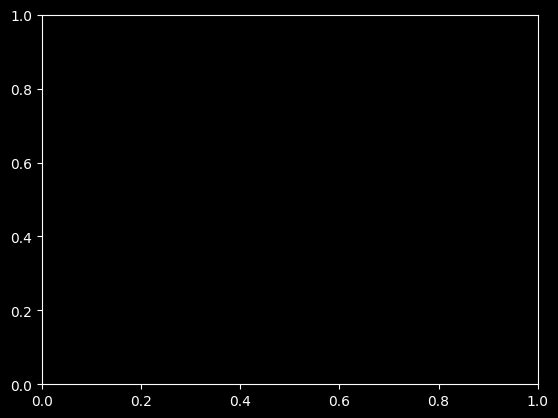

In [ ]:
BaseCNN = BaseConvNet()

criterion = nn.CrossEntropyLoss()

#Initialize optimizer 
learning_rate = .001
optimizer = torch.optim.Adam(BaseCNN.parameters(), lr = learning_rate)


# Device configuration (choose GPU if it is available )
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
num_epochs = 5

# Train and test the model
loss_hist = train_sched(BaseCNN, train_loader, optimizer, num_epochs, model_name='scheduled_model.pkt', device=device, scheduler=True)
plt.plot(loss_hist)
plt.show()


print('Test accuracy is: {} %'.format(test(BaseCNN, test_loader)))

#### Batch Hard

In [ ]:
def get_batch_hard(CNN, train_loader, prop=0.7, device='cpu'):
    with torch.no_grad():
        losses = []
        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.to(device)
            # get network predictions
            outputs = CNN(images)
            # get loss
            loss = criterion(outputs, labels)
            losses.append(loss)
        losses = torch.stack(losses)
        losses = losses.cpu().numpy()
        idx = np.argsort(losses)[::-1]
        idx_hard_batches = idx[:int(len(train_loader)*prop)]
        return idx_hard_batches


def train_hard(CNN, train_loader, optimizer, num_epochs=5, prop=0.7, model_name='hard_model.ckpt', device='cpu', scheduler=None):

# get the batches to run through the model
    idx_hard = get_batch_hard(CNN, train_loader, prop=prop, device=device)
    CNN.train() # Set the model in train mode
    if scheduler is not None: scheduler = lrs.ExponentialLR(optimizer, gamma=0.95) 
    total_step = len(train_loader)
    losses_list = []
    
    # Iterate over epochs
    for epoch in range(num_epochs):
        # Iterate the dataset
        loss_avg = 0
        nBatches = 0
        for i, (images, labels) in enumerate(train_loader):
            if i not in idx_hard: continue
            # Get batch of samples and labels
            images = images.to(device)
            labels = labels.type(torch.LongTensor).to(device)

            # Forward pass
            outputs = CNN(images)
            loss = criterion(outputs, labels)
            
            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            losses_list.append(loss.cpu().item())
            loss_avg += loss.cpu().item()
            nBatches+=1
            if (i+1) % 100 == 0:
                if scheduler is not None:
                    for param_group in optimizer.param_groups:
                        print("Current learning rate is: {}".format(param_group['lr']))
                print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                       .format(epoch+1, num_epochs, i+1, total_step, loss_avg / nBatches))
        print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                       .format(epoch+1, num_epochs, i+1, total_step, loss_avg / nBatches))
        if scheduler is not None: scheduler.step()
        

        # losses_list.append(loss_avg / nBatches)
        torch.save(CNN.state_dict(), results_path+ '/' + model_name)
          
    return losses_list 

Epoch [1/3], Step [100/287], Loss: 1.0192
Epoch [1/3], Step [200/287], Loss: 0.6908
Epoch [2/3], Step [100/287], Loss: 0.6525
Epoch [2/3], Step [200/287], Loss: 0.4616
Epoch [3/3], Step [100/287], Loss: 0.4477
Epoch [3/3], Step [200/287], Loss: 0.4000
Epoch [1/2], Step [100/287], Loss: 0.4526
Epoch [1/2], Step [200/287], Loss: 0.4504
Epoch [1/2], Step [287/287], Loss: 0.4512
Epoch [2/2], Step [100/287], Loss: 0.4339
Epoch [2/2], Step [200/287], Loss: 0.4316
Epoch [2/2], Step [287/287], Loss: 0.4299


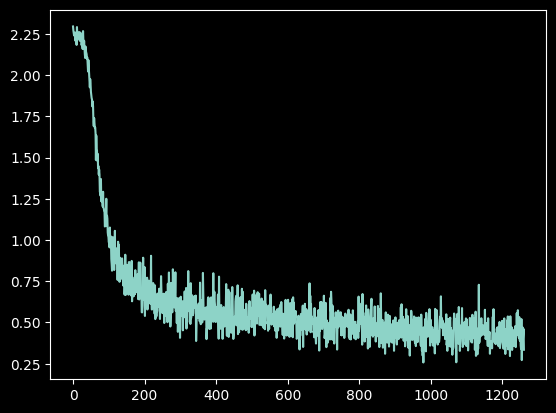

Test accuracy is: 86.11324523663184 %


In [ ]:
BaseCNN = BaseConvNet()

criterion = nn.CrossEntropyLoss()

#Initialize optimizer 
learning_rate = .001
optimizer = torch.optim.Adam(BaseCNN.parameters(), lr = learning_rate)


# Device configuration (choose GPU if it is available )
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
num_epochs_ez = 3
# Train and test the model
loss_hist_ez = train(BaseCNN, train_loader, optimizer, num_epochs_ez, model_name='ez_model.pkt', device=device)

num_epochs_hard = 2
loss_hist_hard = train_hard(BaseCNN, train_loader, optimizer, num_epochs_hard, prop=0.7, model_name='hard_model.pkt', device=device)

loss_hist = loss_hist_ez + loss_hist_hard
plt.plot(loss_hist)
plt.show()


print('Test accuracy is: {} %'.format(test(BaseCNN, test_loader)))

# Ex. 2

# **Building your own efficient Convolutional Network architecture for SVHN**

In the following,  you will need to build your own CNN architecture to predict digit numbers on the SVHN dataset. You are completely free to use any kind of layers and hyper-parameters for this purpose. Your goal is to acheive the maximum possible accuracy on the test set (the better, the higher score you'll get in the exercice). The only constraint is that your model should not contain more than 150K parameters. Below, we provide a simple code to compute the number of parameters in a model.

## Computing model parameters

In [11]:
# Compute model paramters
def compute_model_params(model):
  params = 0
  for p in model.parameters():
    params+= p.numel()
  return params

In [13]:
import torch
import torch.nn as nn

# ResNet style network
class ResSim(nn.Module):
    def __init__(self, num_classes=10):
        
        super(ResSim, self).__init__()
        
    
        self.conv11 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1)
        self.conv12 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)
        
        self.conv21 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)
        self.conv22 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)
        
        self.fc = nn.Linear(8*8*64, num_classes)
        
        self.maxpool= nn.MaxPool2d(kernel_size=2, stride=2)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        
        out11 = self.relu(self.conv11(x))
        out12 = self.relu(self.conv12(out11)) + out11

        out = self.maxpool(out12)

        out21 = self.relu(self.conv21(out)) 
        out = self.relu(self.conv22(out21)) + out21
        out = self.maxpool(out)
        
        #print(out.shape)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        
        return out
# Initialize the model
model = ResSim(num_classes=10)
# Compute and print number of params
n_params = compute_model_params(model)
print("ResNet Parameters: " + str(n_params)) ## 
print("THIS MODEL CONTAINS 153K PARAMS, IT IS CONSIDERED NOT VALID FOR THE EXERCICE!!!!!!")

ResNet Parameters: 153546
THIS MODEL CONTAINS 153K PARAMS, IT IS CONSIDERED NOT VALID FOR THE EXERCICE!!!!!!


In [ ]:
'''
1. Design and implement your own CNN. Given that the number of parameters must be small, you can check some papers focused on efficient CNN architectures and get some ideas.
  - MobileNet: https://arxiv.org/abs/1704.04861
  - MobileNet V2: https://arxiv.org/pdf/1801.04381.pdf
  - SqueezeNet: https://arxiv.org/abs/1602.07360
  - ShuffleNet: https://arxiv.org/abs/1707.01083
  - ESPNet V2: https://arxiv.org/abs/1811.11431
2. Train it and test it on SVHN using the provided code.
3. Discuss what approaches have you tried, why, and which ones have shown to be more beneficial.
'''


## Sol. 2

### Define your own model and check the number of total parameters

In [ ]:
class DWSConv(nn.Module): # depth-wise separable convolution
    def __init__(self, nin, nout):
        super(DWSConv, self).__init__()
        self.depthwise = nn.Conv2d(nin, nin, kernel_size=3, padding=1, groups=nin)
        self.pointwise = nn.Conv2d(nin, nout, kernel_size=1)

    def forward(self, x):
        out = self.depthwise(x)
        out = self.pointwise(out)
        return out

In [37]:
# Define an standard CNN -> Two conv. blocks and linear layer 
import torch.nn as nn
class GavamarNet(nn.Module):
    def __init__(self, num_classes=10):
        
        super(GavamarNet, self).__init__()
        
        self.conv11 = nn.Conv2d(3, 16, kernel_size=3,  padding=1) 
        self.conv12 = nn.Conv2d(16, 16, kernel_size=3, padding=1)
        self.conv13 = nn.Conv2d(16, 16, kernel_size=3, padding=1)
        # after maxpooling, the dimensions are 16x16x16

        self.conv21 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.conv22 = nn.Conv2d(32, 32, kernel_size=3, padding=1)
        self.conv23 = nn.Conv2d(32, 32, kernel_size=3, padding=1)
        # after maxpooling, the dimensions are 8x8x32

        self.conv31 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv32 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.conv33 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        # after maxpooling, the dimensions are 4x4x64
        
        self.fc = nn.Linear(4*4*64, num_classes,)
        
        self.maxpool= nn.MaxPool2d(kernel_size=2, stride=2)
        self.avgpool= nn.AvgPool2d(kernel_size=2, stride=2)

        self.relu = nn.ReLU()
        self.bn12 = nn.BatchNorm2d(16)
        self.bn13 = nn.BatchNorm2d(16)
        self.bn14 = nn.BatchNorm2d(16)

        self.bn22 = nn.BatchNorm2d(32)
        self.bn23 = nn.BatchNorm2d(32)
        self.bn24 = nn.BatchNorm2d(32)

        self.bn32 = nn.BatchNorm2d(64)
        self.bn33 = nn.BatchNorm2d(64)
        self.bn34 = nn.BatchNorm2d(64)
        # self.logsoftmax = nn.LogSoftmax(dim=1).cuda()

# 
        
    def forward(self, x):
        
        out11 = self.conv11(x)
        out12 = self.relu(self.bn12(out11)) #preactivation
        out12 = self.conv12(out12) #convolution
        out13 = self.conv13(self.relu(self.bn13(out13))) #residual connection
        out   = out11 + out13 #skip connection
        out   = self.relu(self.bn14(out)) #postactivation
        out   = self.maxpool(out)

        out21 = self.conv21(out)
        out22 = self.conv22(self.relu(self.bn22(out21))) #preactivation and convolution
        out23 = self.conv23(self.relu(self.bn23(out22))) #residual connections
        out   = out21 + out23 #skip connection
        out   = self.relu(self.bn24(out)) #postactivation
        out   = self.maxpool(out)

        out31 = self.conv31(out)
        out32 = self.conv32(self.relu(self.bn32(out31))) #preactivation and convolution
        out33 = self.conv33(self.relu(self.bn33(out32))) #residual connections
        out   = out31 + out33 #skip connection
        out   = self.relu(self.bn34(out)) #postactivation
        out   = self.avgpool(out)
       
        out = out.reshape(out.size(0), -1) 
        out = self.fc(out)
        return out 

model = GavamarNet(num_classes=10)
n_params = compute_model_params(model)
print("MyModel Parameters: " + str(n_params))


MyModel Parameters: 131498


### Train your model on SVHN
It is not allowed to change training hyper-parameters such as learning rate, batch size or number of epochs. You can only modify the architecture definition.

In [18]:
## Create SVHN database

# All the data will be loaded from the provided file in Data/mnist.t
import torch 
import torch.nn as nn
import torchvision
import torchvision.transforms as tf
import matplotlib.pyplot as plt
from PIL import Image
import scipy.io as sio
import numpy as np

try: 
    base_path
except NameError:
    base_path = os.getcwd().replace('\\','/')
data_path = base_path + '/Data/'
results_path = base_path + '/Results/'

#Making native class loader
class SVHN(torch.utils.data.Dataset):
    # Initialization method for the dataset
    def __init__(self,dataDir = data_path+'/svhn/train_32x32.mat',transform = None):
        mat_loaded = sio.loadmat(dataDir)
        self.data = mat_loaded['X']
        self.labels = mat_loaded['y'].squeeze()
        self.labels -= self.labels.min()
        self.transform = transform
     # What to do to load a single item in the dataset ( read image and label)    
    def __getitem__(self, index):
        data = self.data[:,:,:,index]
        lbl = self.labels[index]
        
        data = Image.fromarray(data)
        # Apply a trasnformaiton to the image if it is indicated in the initalizer
        if self.transform is not None : 
            data = self.transform(data)
        
        # return the image and the label
        return data,lbl
    
        pass
    
    # Return the number of images
    def __len__(self):
        return self.data.shape[3]

# Create train data loader
tr = tf.Compose([
        tf.ToTensor(), 
        tf.Normalize(mean = [.5], std = [.5])
        ])
SVHNTrain = SVHN(data_path+'/svhn/train_32x32.mat',tr)
train_loader = torch.utils.data.DataLoader(dataset=SVHNTrain,
                                               batch_size=256, 
                                               shuffle=True)

In [19]:
# Train function
def train(CNN, train_loader, optimizer, num_epochs=5, model_name='model.ckpt', device='cpu'):
    CNN.train() # Set the model in train mode
    total_step = len(train_loader)
    losses_list = []
    criterion = nn.CrossEntropyLoss()
    # Iterate over epochs
    for epoch in range(num_epochs):
        # Iterate the dataset
        loss_avg = 0
        nBatches = 0
        for i, (images, labels) in enumerate(train_loader):
            # Get batch of samples and labels
            images = images.to(device)
            labels = labels.type(torch.LongTensor).to(device)

            # Forward pass
            outputs = CNN(images)
            loss = criterion(outputs, labels)
            
            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            loss_avg += loss.cpu().item()
            nBatches+=1
            if (i+1) % 100 == 0:
                print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                       .format(epoch+1, num_epochs, i+1, total_step, loss_avg / nBatches))
        print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                       .format(epoch+1, num_epochs, i+1, total_step, loss_avg / nBatches))
        losses_list.append(loss_avg / nBatches)
        torch.save(CNN.state_dict(), results_path+ '/' + model_name)
          
    return losses_list 

# Test funcion
def test(CNN, test_loader):
  with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            # get network predictions
            outputs = CNN(images)

            # get predicted class
            _, predicted = torch.max(outputs.data, 1)

            # compare with the ground-truth
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        # return accuracy
        return 100 * correct / total

In [20]:
#Train MyModel
my_model = GavamarNet()

#Initialize optimizer 
learning_rate = .1
optimizer = torch.optim.SGD(my_model.parameters(),lr = learning_rate, 
                            weight_decay=1e-5, momentum=0.9)


device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
my_model = my_model.to(device)

losses_list = train(my_model, train_loader, optimizer, num_epochs=10, model_name='GavamarNet.ckpt', device=device)


Epoch [1/10], Step [100/287], Loss: 1.0726
Epoch [1/10], Step [200/287], Loss: 0.7494
Epoch [1/10], Step [287/287], Loss: 0.6248
Epoch [2/10], Step [100/287], Loss: 0.2890
Epoch [2/10], Step [200/287], Loss: 0.2807
Epoch [2/10], Step [287/287], Loss: 0.2761
Epoch [3/10], Step [100/287], Loss: 0.2211
Epoch [3/10], Step [200/287], Loss: 0.2224
Epoch [3/10], Step [287/287], Loss: 0.2238
Epoch [4/10], Step [100/287], Loss: 0.1913
Epoch [4/10], Step [200/287], Loss: 0.1945
Epoch [4/10], Step [287/287], Loss: 0.1931
Epoch [5/10], Step [100/287], Loss: 0.1565
Epoch [5/10], Step [200/287], Loss: 0.1682
Epoch [5/10], Step [287/287], Loss: 0.1690
Epoch [6/10], Step [100/287], Loss: 0.1436
Epoch [6/10], Step [200/287], Loss: 0.1492
Epoch [6/10], Step [287/287], Loss: 0.1483
Epoch [7/10], Step [100/287], Loss: 0.1209
Epoch [7/10], Step [200/287], Loss: 0.1284
Epoch [7/10], Step [287/287], Loss: 0.1327
Epoch [8/10], Step [100/287], Loss: 0.1033
Epoch [8/10], Step [200/287], Loss: 0.1128
Epoch [8/10

### Test your model
As a reference, 93% of accuracy can be easily achieved by using only ~55000 parameters.

In [22]:
# Show results for all the trained models
SVHNTest = SVHN(data_path+'/svhn/test_32x32.mat',tr)
test_loader = torch.utils.data.DataLoader(dataset=SVHNTest,
                                               batch_size=256, 
                                               shuffle=True)

#
my_net = GavamarNet()
my_net.load_state_dict(torch.load(results_path + 'GavamarNet.ckpt'))
my_net.to(device)
acc = test(my_net, test_loader)
print('Accuracy MyNet: ' + str(acc))

Accuracy MyNet: 93.68085433312845


# Ex. 3

In [ ]:
'''
1. Use the implemented architecture in the previous exercice to solve the transfer learning
   task provided in the examples.
2. Try to fine-tune not only the last layer for the CNN but a larger subset of parameters.
2. Report the test accuracy in each case and discuss the results. 
'''

## Sol. 3

### Initialize DataLoaders for Transfer Learning experiment

In [24]:
max_degree = 10
tr = tf.Compose([
        tf.ToTensor(),
        tf.Normalize(mean = [.5], std = [.5]),
        tf.RandomCrop(32, padding=4),
        tf.RandomRotation(max_degree)
        ])

# Big dataset with numbers from 1 to 8
SVHNTrain_TL = SVHN(data_path+'/svhn_tl/tl_train_32x32.mat',tr)
tl_train_loader = torch.utils.data.DataLoader(dataset=SVHNTrain_TL,
                                               batch_size=256, 
                                               shuffle=True)

# 200 samples of 0s and 9s
SVHNTrain_TL_0_9 = SVHN(data_path+'/svhn_tl/tl_train_9_10_32x32.mat',tr)
tl_train_loader_0_9 = torch.utils.data.DataLoader(dataset=SVHNTrain_TL_0_9,
                                                  batch_size=64, 
                                                  shuffle=True)
# Test dataset with 0 and 9s
SVHNTest_TL_0_9 = SVHN(data_path+'/svhn_tl/tl_test_9_10_32x32.mat',tr)
tl_test_loader_0_9 = torch.utils.data.DataLoader(dataset=SVHNTest_TL_0_9,
                                                  batch_size=64, 
                                                  shuffle=True)

### Pre-train your model with the big dataset with numbers from 1 to 8

In [25]:

gavamarnet_tl = GavamarNet(num_classes=8)
#Initialize optimizer 
learning_rate = .1
optimizer = torch.optim.SGD(gavamarnet_tl.parameters(),lr = learning_rate, weight_decay=1e-5, momentum=0.9)

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
gavamarnet_tl = gavamarnet_tl.to(device)

losses_it = train(gavamarnet_tl, tl_train_loader, optimizer, num_epochs=10, model_name='tl_gavamarnet_svhn.ckpt', device=device)


Epoch [1/10], Step [100/249], Loss: 1.3867
Epoch [1/10], Step [200/249], Loss: 1.0087
Epoch [1/10], Step [249/249], Loss: 0.9058
Epoch [2/10], Step [100/249], Loss: 0.4041
Epoch [2/10], Step [200/249], Loss: 0.3791
Epoch [2/10], Step [249/249], Loss: 0.3718
Epoch [3/10], Step [100/249], Loss: 0.3066
Epoch [3/10], Step [200/249], Loss: 0.3033
Epoch [3/10], Step [249/249], Loss: 0.2977
Epoch [4/10], Step [100/249], Loss: 0.2641
Epoch [4/10], Step [200/249], Loss: 0.2586
Epoch [4/10], Step [249/249], Loss: 0.2578
Epoch [5/10], Step [100/249], Loss: 0.2385
Epoch [5/10], Step [200/249], Loss: 0.2391
Epoch [5/10], Step [249/249], Loss: 0.2385
Epoch [6/10], Step [100/249], Loss: 0.2235
Epoch [6/10], Step [200/249], Loss: 0.2208
Epoch [6/10], Step [249/249], Loss: 0.2215
Epoch [7/10], Step [100/249], Loss: 0.2083
Epoch [7/10], Step [200/249], Loss: 0.2080
Epoch [7/10], Step [249/249], Loss: 0.2083
Epoch [8/10], Step [100/249], Loss: 0.1992
Epoch [8/10], Step [200/249], Loss: 0.2033
Epoch [8/10

### Fine-tune the pretrained network with the small dataset of 9s and 0s

In [38]:
import time
criterion = nn.CrossEntropyLoss()
model = GavamarNet(num_classes=8)
layers = ['11', '12', '13', '21', '22', '23', '31', '32', '33', 'fc']
arr_acc = []
arr_time = []
layers_to_freeze = list(range(1,len(layers)))
for num_freeze in layers_to_freeze:
    # copy the pretrained model
    fine_tuned_model = GavamarNet(num_classes=8)
    fine_tuned_model.load_state_dict(torch.load(results_path + 'tl_gavamarnet_svhn.ckpt'))
    fine_tuned_model = fine_tuned_model.to(device)
    fine_tuned_model.fc = nn.Linear(4*4*64, 2).cuda()
    
    # freeze layers
    for name, param in model.named_parameters():
        if any(layer in name for layer in layers[:num_freeze]):
            param.requires_grad = False
            print(name, 'layer frozen')
    # get the optimizer
    learning_rate = .0005
    optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, fine_tuned_model.parameters()),lr = learning_rate,
                                 weight_decay=1e-5)
    
    start_time = time.time()
    losses_freeze = train(fine_tuned_model, tl_train_loader_0_9, optimizer, num_epochs=10, model_name=f'tl_gavamarnet_svhn_{num_freeze}.ckpt', device=device)
    end_time = time.time()
    arr_time.append(end_time - start_time)
    plt.plot(losses_freeze)
    plt.title("Loss for layers freezed "+str(layers[:num_freeze]))
    plt.xlabel("step")
    plt.ylabel("Loss")
    plt.show()
    acc = test(fine_tuned_model, tl_test_loader_0_9)
    arr_acc.append(acc)
    print('Accuracy ResNet Transfer Learning with layers freezed '+str(layers[:num_freeze])+': ' + str(acc),"\n")


RuntimeError: Error(s) in loading state_dict for GavamarNet:
	Missing key(s) in state_dict: "bn14.weight", "bn14.bias", "bn14.running_mean", "bn14.running_var", "bn24.weight", "bn24.bias", "bn24.running_mean", "bn24.running_var", "bn34.weight", "bn34.bias", "bn34.running_mean", "bn34.running_var". 
	Unexpected key(s) in state_dict: "bn11.weight", "bn11.bias", "bn11.running_mean", "bn11.running_var", "bn11.num_batches_tracked", "bn21.weight", "bn21.bias", "bn21.running_mean", "bn21.running_var", "bn21.num_batches_tracked", "bn31.weight", "bn31.bias", "bn31.running_mean", "bn31.running_var", "bn31.num_batches_tracked". 

Plot of the accuracy and time computation for the training and validation sets during the fine-tuning process.

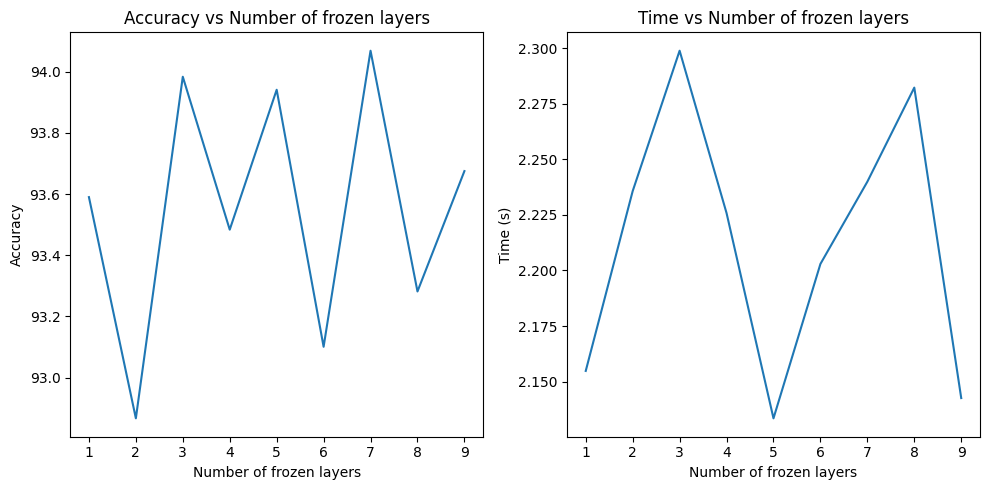

In [36]:

fig,axs = plt.subplots(1,2,figsize=(10,5))
axs[0].plot(layers_to_freeze,arr_acc)
axs[0].set_xlabel('Number of frozen layers')
axs[0].set_ylabel('Accuracy')
axs[0].set_title('Accuracy vs Number of frozen layers')
axs[1].plot(layers_to_freeze,arr_time)
axs[1].set_xlabel('Number of frozen layers')
axs[1].set_ylabel('Time (s)')
axs[1].set_title('Time vs Number of frozen layers')
fig.tight_layout()
plt.show()

### Demonstrating that  training from scratch is worse than transfer learning

In [27]:

gavamarnet_tl = GavamarNet(num_classes=2)
#Initialize optimizer 
learning_rate = .0005
optimizer = torch.optim.Adam(gavamarnet_tl.parameters(),lr = learning_rate)

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
gavamarnet_tl = gavamarnet_tl.to(device)

losses_it = train(gavamarnet_tl, tl_train_loader_0_9, optimizer, num_epochs=10, model_name='tl_gavamarnet_svhn_only_0_9.ckpt', device=device)

acc= test(gavamarnet_tl, tl_test_loader_0_9)
print('Accuracy MyNet: ' + str(acc))

Epoch [1/10], Step [4/4], Loss: 0.7206
Epoch [2/10], Step [4/4], Loss: 0.6908
Epoch [3/10], Step [4/4], Loss: 0.5960
Epoch [4/10], Step [4/4], Loss: 0.5569
Epoch [5/10], Step [4/4], Loss: 0.4969
Epoch [6/10], Step [4/4], Loss: 0.5628
Epoch [7/10], Step [4/4], Loss: 0.4753
Epoch [8/10], Step [4/4], Loss: 0.4588
Epoch [9/10], Step [4/4], Loss: 0.4059
Epoch [10/10], Step [4/4], Loss: 0.3609
Accuracy MyNet: 69.78845540554906
